In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [122]:
df = pd.read_csv('example.csv')
df.head()

,y,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11
0,15,76.536552,12.5416,2.0771,221.551300,10.0,139.800003,85.857498,47.096699,1010.956116,28.665501,2
1,15,75.900604,7.9399,3.0989,222.065201,10.4,138.399994,87.915199,46.145401,1009.044922,28.609100,3
2,18,75.860214,7.4337,1.5645,222.836105,11.0,137.199997,90.080101,47.602299,1010.371582,28.605499,3
3,18,75.590706,10.3336,1.0435,222.797104,11.3,135.800003,87.712898,40.327999,1010.856018,28.581400,0
4,18,74.890808,8.9959,1.0436,222.287598,11.5,134.699997,93.206100,40.362000,1011.369324,28.518299,0


In [123]:
# 1. 基础信息探索
print(f"数据集规模：{df.shape}")
print(f"台风强度统计：范围{df['y'].min():.1f}-{df['y'].max():.1f}，均值{df['y'].mean():.2f}")
print("\n缺失值统计：")
print(df.isnull().sum())
print("\n重复值统计：")
print(df.duplicated().sum())

数据集规模：(2232, 12)
台风强度统计：范围10.0-75.0，均值28.19

缺失值统计：
y       0
x_1     0
x_2     0
x_3     0
x_4     0
x_5     0
x_6     0
x_7     0
x_8     0
x_9     0
x_10    0
x_11    0
dtype: int64

重复值统计：
0


In [124]:
# 2.异常值统计
print("x_10异常值统计：")
x10_outlier_count = (df['x_10'] == 9999).sum()
print(f"9999值数量：{x10_outlier_count}，占比：{x10_outlier_count/len(df)*100:.1f}%")

x_10异常值统计：
9999值数量：180，占比：8.1%


In [125]:
# 3.台风等级划分
def classify_typhoon(wind_speed):
    if 10.8 <= wind_speed < 17.2:
        return "热带低压"
    elif 17.2 <= wind_speed < 32.7:
        return "台风"
    else:
        return "强台风"

df['typhoon_grade'] = df['y'].apply(classify_typhoon)
print("\n台风等级分布：")
print(df['typhoon_grade'].value_counts(normalize=True).round(3)*100)


台风等级分布：
typhoon_grade
台风      46.3
强台风     35.2
热带低压    18.5
Name: proportion, dtype: float64


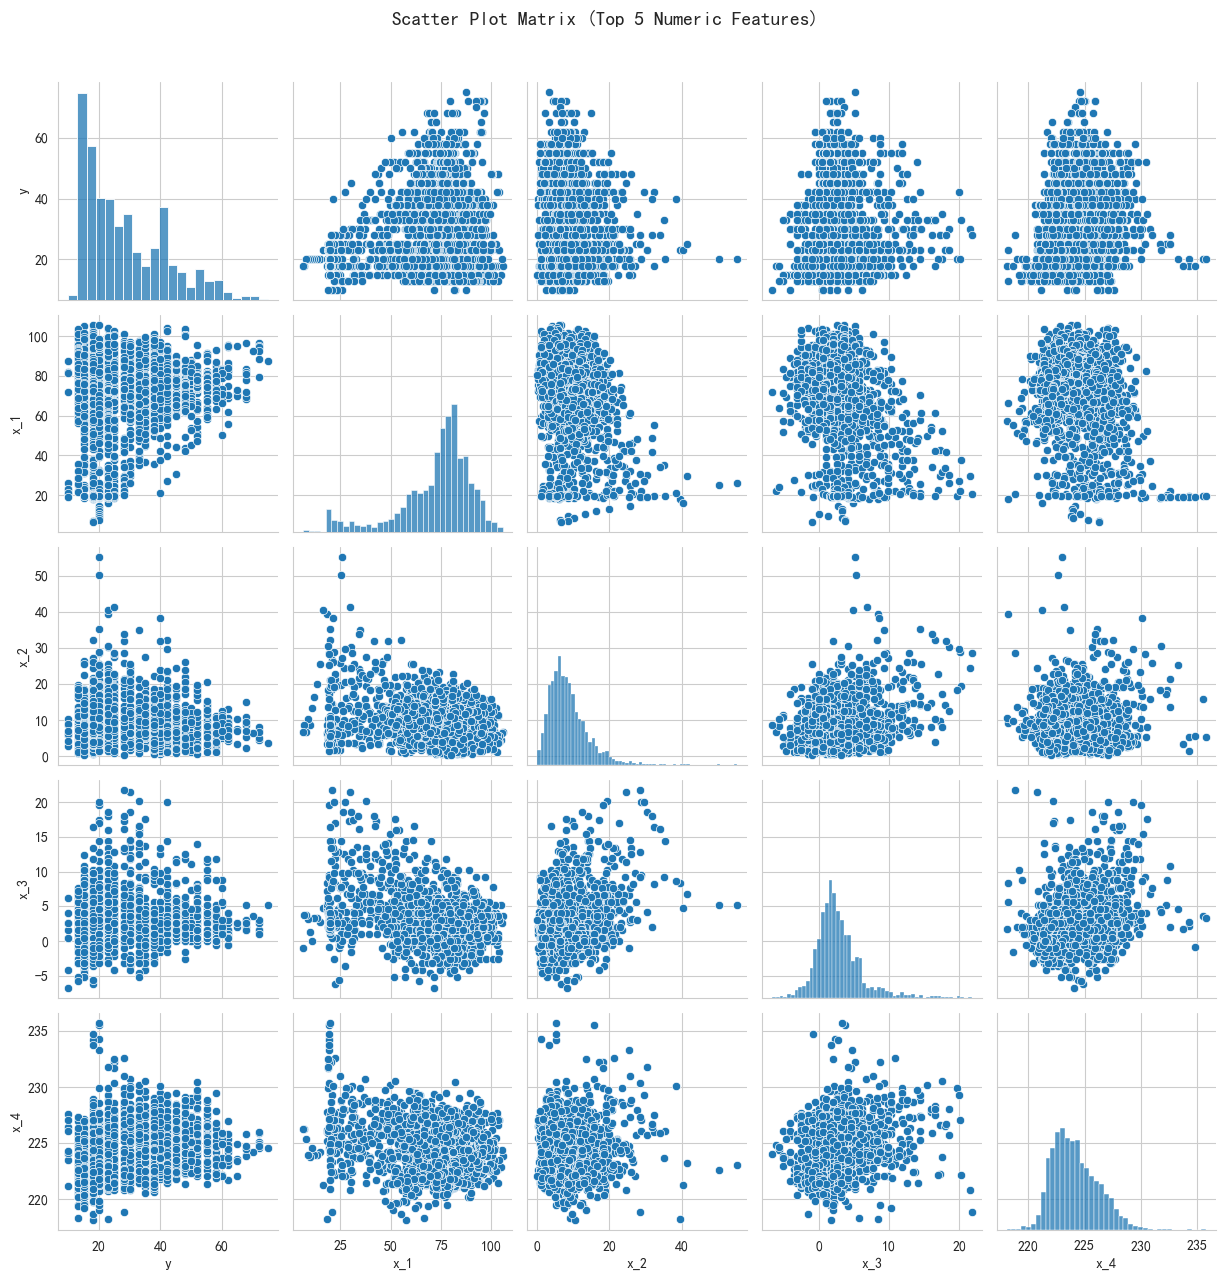

In [126]:
# 4.可视化分析
# 筛选数值特征
vis_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# 散点图矩阵
sns.pairplot(df[vis_features[:5]])  # 取前5个特征避免图过于密集
plt.suptitle('Scatter Plot Matrix (Top 5 Numeric Features)', y=1.02, fontsize=14)
plt.tight_layout()
plt.savefig('散点图.png', dpi=300)
plt.show()

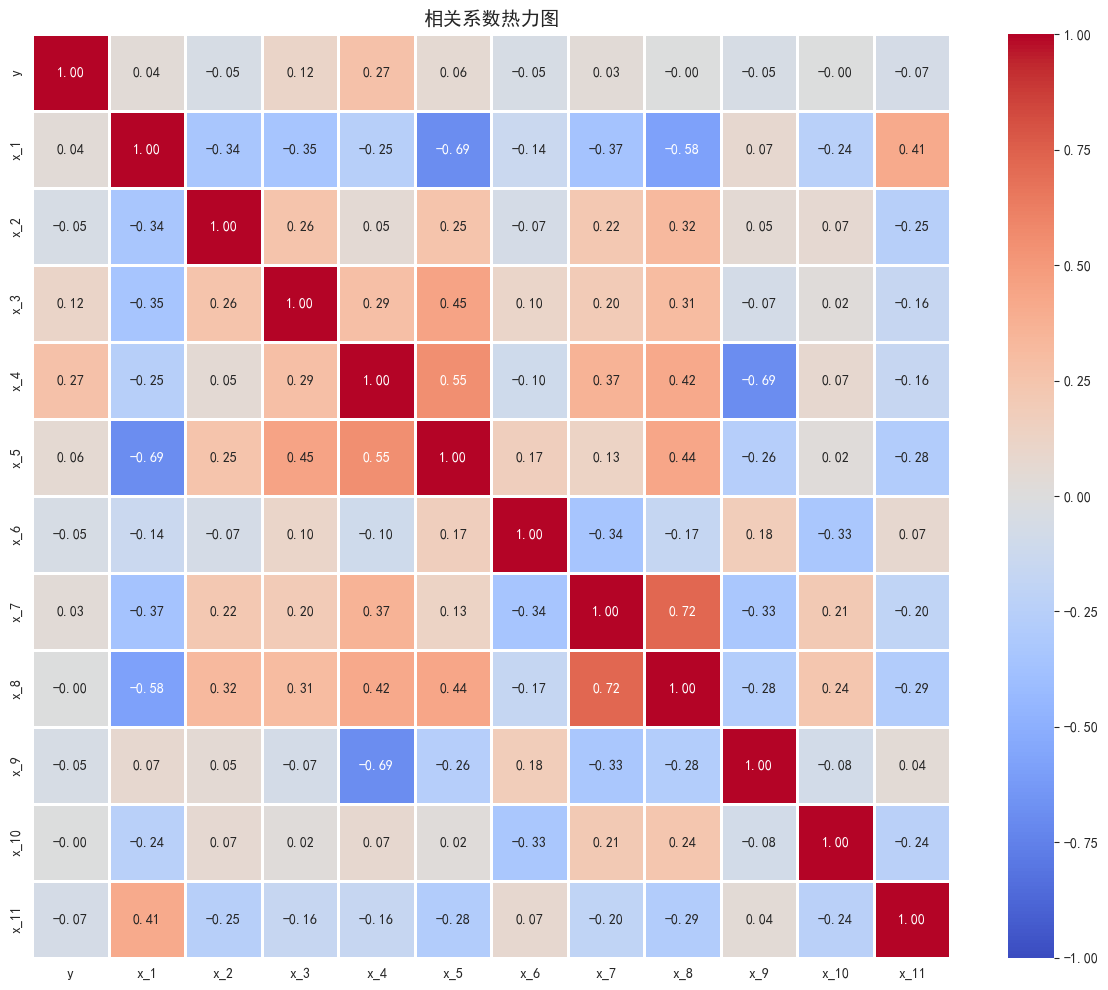

In [127]:
# 相关系数热力图
corr_matrix = df[vis_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=0.8,
    vmin=-1, vmax=1
)
plt.title('相关系数热力图', fontsize=14)
plt.tight_layout()
plt.savefig('相关系数热力图.png', dpi=300)
plt.show()


In [128]:
# 5.数据预处理
from sklearn.model_selection import train_test_split

# 异常值处理
print("处理x_10的集中异常值（9999）：")
x10_median = df[df['x_10'] != 9999].groupby('typhoon_grade')['x_10'].median()
df['x_10'] = df.apply(
    lambda row: x10_median[row['typhoon_grade']] if row['x_10'] == 9999 else row['x_10'],
    axis=1
)


# 独热编码分箱特征（转为数值型,使模型正确理解类别关系）
df = pd.get_dummies(df, columns=['typhoon_grade'], drop_first=True)

# 特征与标签定义
X = df.drop(["y"], axis=1)
y = df["y"]

处理x_10的集中异常值（9999）：


In [129]:
# 拆分训练集、验证集、测试集（7:1:2比例）
# 训练集：模型训练；验证集：超参数优化与早停；测试集：最终性能评估
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.67, random_state=66)

print(f"训练集规模：{X_train.shape[0]}条样本（70%）")
print(f"验证集规模：{X_val.shape[0]}条样本（10%）")
print(f"测试集规模：{X_test.shape[0]}条样本（20%）")


训练集规模：1562条样本（70%）
验证集规模：221条样本（10%）
测试集规模：449条样本（20%）


In [130]:
# 6.数据建模,集成两个模型，预测更准确
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

models = {}

# 随机森林
rf_model = RandomForestRegressor(
    n_estimators=400,
    max_depth=15,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=66,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['随机森林'] = rf_model

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=66,
    n_jobs=-1,
    early_stopping_rounds=20, # 早停机制：基于验证集性能，30轮无提升则停止训练
)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)
models['XGBoost'] = xgb_model

# 加权集成模型
# 集成逻辑：基于模型在验证集的性能分配权重，性能更优的模型获得更高权重
def weighted_ensemble_predict(X):
    # 计算各模型在验证集的R²得分
    rf_val_r2 = r2_score(y_val, rf_model.predict(X_val))
    xgb_val_r2 = r2_score(y_val, xgb_model.predict(X_val))
    # 权重分配：模型性能占比
    total_weight = rf_val_r2 + xgb_val_r2
    rf_weight = rf_val_r2 / total_weight
    xgb_weight = xgb_val_r2 / total_weight
    print(f"集成模型权重分配：随机森林={rf_weight:.2f}，XGBoost={xgb_weight:.2f}")
    # 加权融合预测结果
    return rf_weight * rf_model.predict(X) + xgb_weight * xgb_model.predict(X)

models['加权集成'] = weighted_ensemble_predict

In [131]:
# 7.模型评估
from sklearn.metrics import r2_score, mean_absolute_error


# 定义评估函数：计算R²与MAE
def model_evaluation(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return pd.Series([r2, mae], index=['R²', 'MAE'], name=model_name)

# 批量评估所有模型
evaluation_results = pd.DataFrame()
for model_name, model in models.items():
    if model_name == '加权集成':
        y_pred = model(X_test)  # 集成模型直接调用预测函数
    else:
        y_pred = model.predict(X_test)  # 单模型调用predict方法
    eval_res = model_evaluation(y_test, y_pred, model_name)
    evaluation_results = pd.concat([evaluation_results, eval_res], axis=1)

# 转置结果表格，优化展示格式
evaluation_results = evaluation_results.T.round(3)
print("测试集性能评估结果：")
print(evaluation_results)

# 确定最优模型（基于R²指标）
best_model_name = evaluation_results['R²'].idxmax()
best_r2 = evaluation_results.loc[best_model_name, 'R²']
best_mae = evaluation_results.loc[best_model_name, 'MAE']
print(f"\n最优模型：{best_model_name}")
print(f"最优性能：R²={best_r2}，MAE={best_mae} ")
print("结论：加权集成模型融合了随机森林与XGBoost的优势，实现了最优预测性能")

集成模型权重分配：随机森林=0.50，XGBoost=0.50
测试集性能评估结果：
            R²    MAE
随机森林     0.885  2.993
XGBoost  0.885  3.010
加权集成     0.889  2.910

最优模型：加权集成
最优性能：R²=0.889，MAE=2.91 
结论：加权集成模型融合了随机森林与XGBoost的优势，实现了最优预测性能
